In [1]:
#we start by importing out libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



In [2]:
import numpy as np
np.float_ = np.float64

In [3]:
import prophet

c:\Users\djibr\Documents\Projects\Analytics_projects\analytics_projects\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
#Now we import our data dict
data_dict = pd.read_excel('./Fin_data_01.xlsx', sheet_name= 'dictionary')
data_dict

,Year,Year of revenue/expense
0,Month - name,Month of revenue/expense
1,Month -sequence,"Month of revenue/expense, expressed as number"
2,Date,"Date of revenue/expense, expressed as the last..."
3,Business Line,Business line generating revenue / expense (Sp...
4,"Amount, $",Revenue or expense amount in USD
5,Expense subgroup,Additional subgroups categorizing expenses ass...
6,Income / Expense Group,Subcategory of revenue / expense. Revenue subc...
7,Income or expense,Column indicating if associated amount is reve...
8,NaN,NaN
9,NaN,NaN


We start by describing our dataset with summary statistics

In [5]:
Fin_data = pd.read_excel('./Fin_data_01.xlsx')
Fin_data

,Year,Month - name,Month -sequence,Date,Business Line,"Amount, $",Expense subgroup,Revenue / Expense Group,Revenue or expense
0,2023,January,1,2023-01-31,Nutrition and Food Supplements,153000,NaN,Sales,Revenue
1,2023,January,1,2023-01-31,Nutrition and Food Supplements,27000,NaN,Consulting and professional services,Revenue
2,2023,January,1,2023-01-31,Nutrition and Food Supplements,6000,NaN,Other income,Revenue
3,2023,January,1,2023-01-31,Nutrition and Food Supplements,-15000,Rent,Opex,Expense
4,2023,January,1,2023-01-31,Nutrition and Food Supplements,-9000,Equipment,Opex,Expense
...,...,...,...,...,...,...,...,...,...
575,2023,December,1,2023-12-31,Sportswear,-4000,Packaging,COGS,Expense
576,2023,December,1,2023-12-31,Sportswear,-7000,Shipping,COGS,Expense
577,2023,December,1,2023-12-31,Sportswear,-9000,Sales,COGS,Expense
578,2023,December,1,2023-12-31,Sportswear,-110000,Labor,COGS,Expense


In [6]:
Fin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Year                     580 non-null    int64         
 1   Month - name             580 non-null    object        
 2   Month -sequence          580 non-null    int64         
 3   Date                     580 non-null    datetime64[ns]
 4   Business Line            580 non-null    object        
 5   Amount, $                580 non-null    int64         
 6   Expense subgroup         468 non-null    object        
 7   Revenue / Expense Group  580 non-null    object        
 8   Revenue or expense       580 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 40.9+ KB


In [7]:
Fin_data.describe()

,Year,Month -sequence,Date,"Amount, $"
count,580.0,580.0,580,580.000000
mean,2023.0,1.0,2023-07-15 01:49:14.482758656,7438.137931
min,2023.0,1.0,2023-01-31 00:00:00,-234000.000000
25%,2023.0,1.0,2023-03-31 00:00:00,-30000.000000
50%,2023.0,1.0,2023-06-30 00:00:00,-10800.000000
75%,2023.0,1.0,2023-09-30 00:00:00,-1800.000000
max,2023.0,1.0,2023-12-31 00:00:00,750000.000000
std,0.0,0.0,NaN,118699.587071


In [8]:
Fin_data.columns

Index(['Year', 'Month - name', 'Month -sequence', 'Date', 'Business Line',
       'Amount, $', 'Expense subgroup', 'Revenue / Expense Group',
       'Revenue or expense'],
      dtype='object')

Now we move on to expanding our date columns for effective drill down

In [9]:
#Now we shall rename columns

Fin_data.rename(columns= {'Month - name': 'Month_name'}, inplace= True)

In [10]:
Fin_data.rename(columns= {'Month -sequence' : 'Month_sequence', 'Amount, $': 'Amount', 'Expense subgroup' : 'Expense_subgroup', 'Revenue or expense' : 'Rev_or_exp'
                          , 'Revenue / Expense Group' : 'Rev_exp_group','Business Line': 'Biz_line' }, inplace= True)

In [11]:
#now we extract week from date 

def week_of_mon(col):
    first_day_of_mon = col.replace(day = 1)
    dom = col.day
    adjusted_dom = first_day_of_mon.weekday() + dom
    return int(np.ceil(adjusted_dom)/7)

Fin_data['week'] = Fin_data['Date'].apply(week_of_mon)



In [12]:
Fin_data['week'] = 'week' + ' ' + Fin_data['week'].astype(str)
Fin_data['Quarter'] = Fin_data['Date'].dt.quarter
Fin_data['Quarter'] = 'qtr ' + Fin_data['Quarter'].astype(str)
Fin_data['mon_no'] = Fin_data['Date'].dt.month

Fin_data['Month_name'] = Fin_data['Month_name'].str[:3]

Fin_data

,Year,Month_name,Month_sequence,Date,Biz_line,Amount,Expense_subgroup,Rev_exp_group,Rev_or_exp,week,Quarter,mon_no
0,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,153000,NaN,Sales,Revenue,week 5,qtr 1,1
1,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,27000,NaN,Consulting and professional services,Revenue,week 5,qtr 1,1
2,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,6000,NaN,Other income,Revenue,week 5,qtr 1,1
3,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,-15000,Rent,Opex,Expense,week 5,qtr 1,1
4,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,-9000,Equipment,Opex,Expense,week 5,qtr 1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
575,2023,Dec,1,2023-12-31,Sportswear,-4000,Packaging,COGS,Expense,week 5,qtr 4,12
576,2023,Dec,1,2023-12-31,Sportswear,-7000,Shipping,COGS,Expense,week 5,qtr 4,12
577,2023,Dec,1,2023-12-31,Sportswear,-9000,Sales,COGS,Expense,week 5,qtr 4,12
578,2023,Dec,1,2023-12-31,Sportswear,-110000,Labor,COGS,Expense,week 5,qtr 4,12


In [13]:
Fin_data['mon_day'] = Fin_data['Date'].dt.day

Fin_data['week_day'] = Fin_data['Date'].dt.day_name()

In [ ]:
x = Fin_data['Amount']

We move on to exploring individual columns 

In [14]:
Fin_data['Expense_subgroup'].value_counts()

Expense_subgroup
Other               72
Rent                36
Marketing           36
Equipment           36
Payroll             36
R&D                 36
Materials           36
Packaging           36
Shipping            36
Sales               36
Labor               36
Interest and tax    36
Name: count, dtype: int64

In [15]:
#here we pull data for expenses only

rev_only = Fin_data.query('Rev_or_exp == "Revenue"')
total_rev = rev_only['Amount'].sum()
total_rev

np.int64(17559820)

In [16]:
#now we look into total_expense

exp_only = Fin_data.query('Rev_or_exp == "Expense"')
exp_only
total_exp = exp_only['Amount'].sum()
total_exp

np.int64(-13245700)

In [17]:
Fin_data['Rev_exp_group'].value_counts()

Rev_exp_group
COGS                                    216
Opex                                    216
Other income                             40
Sales                                    36
Consulting and professional services     36
Interest and tax                         36
Name: count, dtype: int64

In [18]:
Fin_data['Rev_or_exp'].value_counts()

Rev_or_exp
Expense    468
Revenue    112
Name: count, dtype: int64

In [19]:
Fin_data.query('Rev_exp_group == "COGS"').head()

,Year,Month_name,Month_sequence,Date,Biz_line,Amount,Expense_subgroup,Rev_exp_group,Rev_or_exp,week,Quarter,mon_no,mon_day,week_day
9,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,-20000,Materials,COGS,Expense,week 5,qtr 1,1,31,Tuesday
10,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,-1200,Packaging,COGS,Expense,week 5,qtr 1,1,31,Tuesday
11,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,-2700,Shipping,COGS,Expense,week 5,qtr 1,1,31,Tuesday
12,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,-3000,Sales,COGS,Expense,week 5,qtr 1,1,31,Tuesday
13,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,-65000,Labor,COGS,Expense,week 5,qtr 1,1,31,Tuesday


In [20]:
Fin_data[['Biz_line', 'Expense_subgroup', 'Amount', 'Rev_exp_group']]

,Biz_line,Expense_subgroup,Amount,Rev_exp_group
0,Nutrition and Food Supplements,NaN,153000,Sales
1,Nutrition and Food Supplements,NaN,27000,Consulting and professional services
2,Nutrition and Food Supplements,NaN,6000,Other income
3,Nutrition and Food Supplements,Rent,-15000,Opex
4,Nutrition and Food Supplements,Equipment,-9000,Opex
...,...,...,...,...
575,Sportswear,Packaging,-4000,COGS
576,Sportswear,Shipping,-7000,COGS
577,Sportswear,Sales,-9000,COGS
578,Sportswear,Labor,-110000,COGS


In [21]:
#Fin_data.loc[Fin_data['Rev_exp_group'] == 'Consulting and professional services',['Biz_line', 'Expense_subgroup', 'Amount', 'Rev_exp_group']]

In [22]:

Fin_data.loc[Fin_data['Rev_exp_group'] == 'COGS',['Biz_line', 'Expense_subgroup', 'Amount', 'Rev_exp_group']].head()

,Biz_line,Expense_subgroup,Amount,Rev_exp_group
9,Nutrition and Food Supplements,Materials,-20000,COGS
10,Nutrition and Food Supplements,Packaging,-1200,COGS
11,Nutrition and Food Supplements,Shipping,-2700,COGS
12,Nutrition and Food Supplements,Sales,-3000,COGS
13,Nutrition and Food Supplements,Labor,-65000,COGS


In [23]:
Fin_data.loc[Fin_data['Rev_exp_group'] == 'Opex',['Biz_line', 'Expense_subgroup', 'Amount', 'Rev_exp_group']].head()

,Biz_line,Expense_subgroup,Amount,Rev_exp_group
3,Nutrition and Food Supplements,Rent,-15000,Opex
4,Nutrition and Food Supplements,Equipment,-9000,Opex
5,Nutrition and Food Supplements,Marketing,-30000,Opex
6,Nutrition and Food Supplements,Payroll,-40000,Opex
7,Nutrition and Food Supplements,R&D,-30000,Opex


Exploratory Data Analysis

In [24]:
#Total revenue, expense and gross profit

df_rev_exp = ['tot_rev', 'tot_exp', 'net_profit']
df_rev_exp = pd.DataFrame(df_rev_exp)

#tot_rev =Fin_data[Fin_data['Rev_or_exp'] == 'Revenue', ['Amount'].sum()]
tot_rev_01 = Fin_data.groupby('Rev_or_exp')['Amount'].sum().reset_index(name= 'Amount')
tot_rev_01

,Rev_or_exp,Amount
0,Expense,-13245700
1,Revenue,17559820


In [25]:
#sns.barplot(x= 'Rev_or_exp', y= 'Amount', data= tot_rev_01 )

Rev and expense across biz lines

In [26]:
#tot_revenue acros biz line

tot_rev_data_ext = Fin_data.loc[Fin_data['Rev_or_exp']== 'Revenue', ['Biz_line', 'Amount', 'Rev_exp_group', 'Rev_or_exp']]


pd.set_option('display.max_rows', 200)
tot_rev_biz_line = tot_rev_data_ext.groupby('Biz_line')['Amount'].sum().reset_index(name = 'tot_rev').sort_values('tot_rev', ascending = False)
tot_rev_biz_line

,Biz_line,tot_rev
1,Sports equipment,8908500
2,Sportswear,6807700
0,Nutrition and Food Supplements,1843620


<Axes: xlabel='Biz_line', ylabel='tot_rev'>

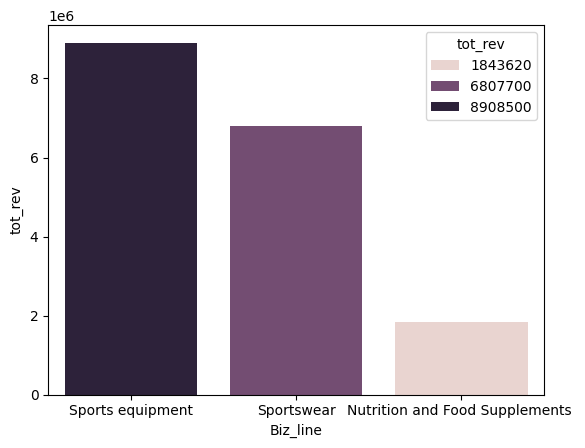

In [27]:
sns.barplot(x= 'Biz_line', y= 'tot_rev', hue= 'tot_rev', data = tot_rev_biz_line)

In [28]:
#df = Fin_data.loc[Fin_data['Rev_or_exp']== 'Revenue', ['Biz_line', 'Amount', 'Rev_exp_group', 'Rev_or_exp']]
#df.head()

In [29]:
#total_expense across biz lines

#first we extract the data needed for expenses

tot_exp_data_ext = Fin_data.loc[Fin_data['Rev_or_exp']=='Expense', ['Biz_line', 'Amount', 'Expense_subgroup','Rev_exp_group', 'Rev_or_exp']]


pd.set_option('display.max_rows', 470)
tot_exp_biz_line = tot_exp_data_ext.groupby('Biz_line')['Amount'].sum().reset_index(name= 'tot_exp').sort_values('tot_exp', ascending = False)
tot_exp_biz_line

,Biz_line,tot_exp
0,Nutrition and Food Supplements,-2556500
2,Sportswear,-4070900
1,Sports equipment,-6618300


<Axes: xlabel='tot_exp', ylabel='Biz_line'>

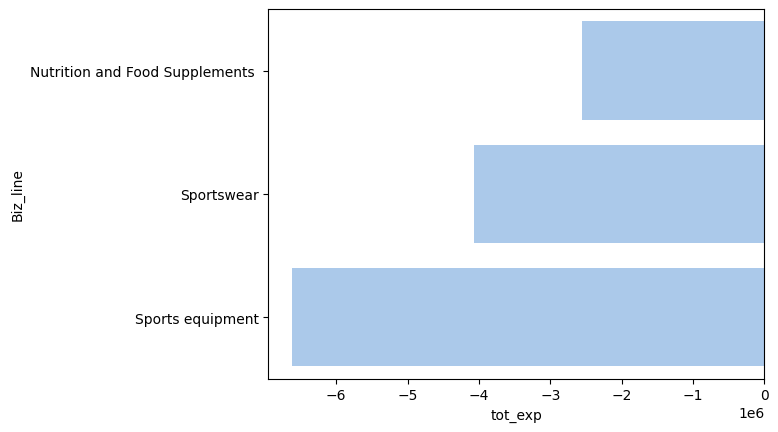

In [30]:
sns.set_color_codes("pastel")
sns.barplot(x= 'tot_exp', y= 'Biz_line', color= 'b', data= tot_exp_biz_line )

In [31]:
#tot exp across various sub_groups

sub_group_tot_exp = tot_exp_data_ext.groupby('Expense_subgroup')['Amount'].sum().reset_index(name = 'tot_exp').sort_values('tot_exp', ascending = True)
sub_group_tot_exp

,Expense_subgroup,tot_exp
2,Labor,-4492000
7,Payroll,-1790000
0,Equipment,-1333000
4,Materials,-1065000
3,Marketing,-1055000
1,Interest and tax,-929400
9,Rent,-745000
8,R&D,-540000
10,Sales,-447000
5,Other,-405500


<Axes: xlabel='tot_exp', ylabel='Expense_subgroup'>

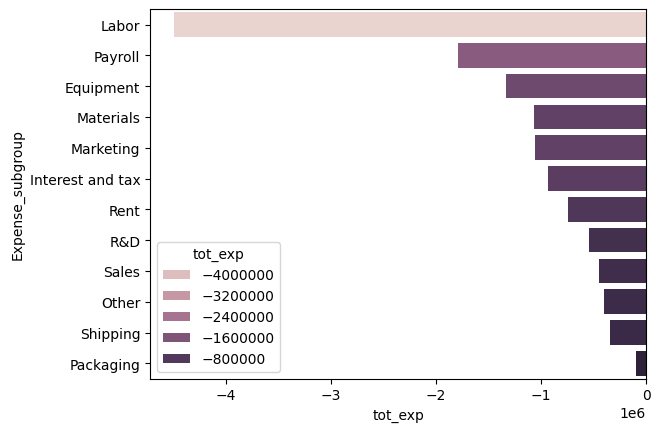

In [32]:
data_01 = sub_group_tot_exp.sort_values('tot_exp', ascending= True)
sns.barplot(x= 'tot_exp', y= 'Expense_subgroup', hue = 'tot_exp', data= data_01)

In [33]:
#total rev across various Rev_exp_group

tot_rev_group = tot_rev_data_ext.groupby('Rev_exp_group')['Amount'].sum().reset_index(name= 'tot_rev').sort_values('tot_rev', ascending= False)
tot_rev_group

,Rev_exp_group,tot_rev
2,Sales,13776630
0,Consulting and professional services,2817000
1,Other income,966190


<Axes: xlabel='Rev_exp_group', ylabel='tot_rev'>

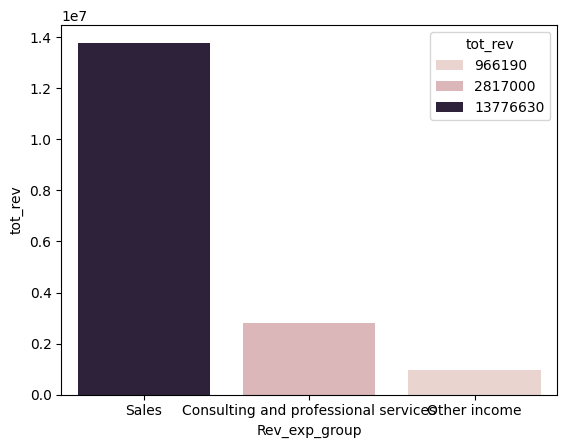

In [34]:
sns.barplot(x= 'Rev_exp_group', y= 'tot_rev', hue= 'tot_rev',  data= tot_rev_group)

In [35]:
#total expenses across various Rev_exp_group

tot_exp_group = tot_exp_data_ext.groupby('Rev_exp_group')['Amount'].sum().reset_index(name= 'tot_exp').sort_values('tot_exp', ascending = True)
tot_exp_group

,Rev_exp_group,tot_exp
0,COGS,-6711500
2,Opex,-5604800
1,Interest and tax,-929400


<Axes: xlabel='Rev_exp_group'>

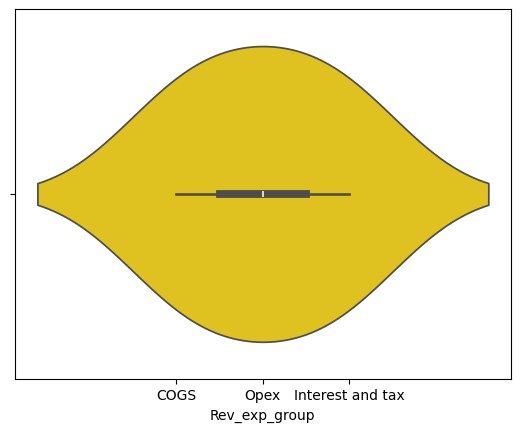

In [36]:
sns.violinplot(x=tot_exp_group['Rev_exp_group'], color= 'gold' )

In [37]:
Fin_data.groupby('Rev_exp_group')['Amount'].sum().reset_index(name='total').sort_values('total', ascending= False)

,Rev_exp_group,total
5,Sales,13776630
1,Consulting and professional services,2817000
4,Other income,966190
2,Interest and tax,-929400
3,Opex,-5604800
0,COGS,-6711500


Overall trend analysis for biz line, expense_subgroup, rev_exp_subgroup and Rev_or_exp_group

Monthly Trends

In [38]:
#extracting required data for trend overview

trend_rev_extract = Fin_data.loc[Fin_data['Rev_or_exp'] == 'Revenue', ['Month_name', 'mon_no', 'Quarter', 'week', 'week_day', 'Biz_line', 'Rev_exp_group', 'Rev_or_exp', 'Amount' ]]

trend_exp_extract = Fin_data.loc[Fin_data['Rev_or_exp'] == 'Expense', ['Month_name', 'mon_no','Quarter', 'week', 'week_day', 'Biz_line', 'Rev_exp_group', 'Expense_subgroup', 'Rev_or_exp', 'Amount' ]]



In [39]:
#total rev by month

tot_rev_by_month = trend_rev_extract.groupby(['mon_no','Month_name'])['Amount'].sum().reset_index(name= 'tot_rev').sort_values('mon_no',ascending = True)
tot_rev_by_month

,mon_no,Month_name,tot_rev
0,1,Jan,1949000
1,2,Feb,1567700
2,3,Mar,1313350
3,4,Apr,1156100
4,5,May,1698500
5,6,Jun,1719200
6,7,Jul,1400050
7,8,Aug,1304850
8,9,Sep,1120890
9,10,Oct,1322475


<Axes: xlabel='Month_name', ylabel='tot_rev'>

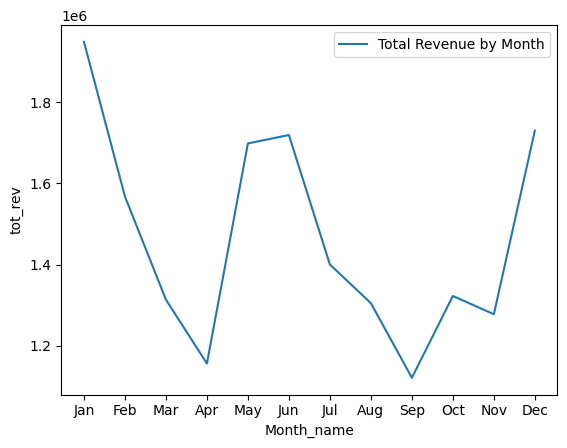

In [40]:
sns.set_color_codes('pastel')
sns.lineplot(x= 'Month_name', y= 'tot_rev', data= tot_rev_by_month, label = 'Total Revenue by Month')

In [41]:
#total exp by month
tot_exp_by_month = trend_exp_extract.groupby(['mon_no','Month_name'])['Amount'].sum().reset_index(name= 'tot_exp').sort_values('mon_no', ascending = True)
tot_exp_by_month


,mon_no,Month_name,tot_exp
0,1,Jan,-1254500
1,2,Feb,-1089000
2,3,Mar,-1010800
3,4,Apr,-963400
4,5,May,-1230900
5,6,Jun,-1226100
6,7,Jul,-1111200
7,8,Aug,-1036300
8,9,Sep,-1029300
9,10,Oct,-1027400


<Axes: xlabel='Month_name', ylabel='tot_exp'>

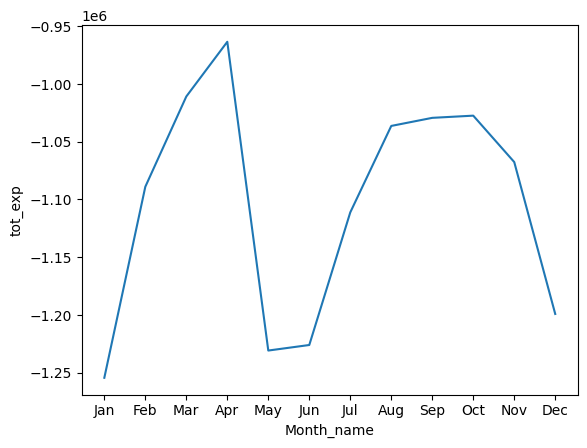

In [42]:
sns.lineplot(x = 'Month_name', y= 'tot_exp', data= tot_exp_by_month)

In [43]:
#month over month change in revenue

tot_rev_by_month['mom_diff'] = tot_rev_by_month['tot_rev'] - tot_rev_by_month['tot_rev'].shift(1)
tot_rev_by_month['mom_%_change'] = tot_rev_by_month['tot_rev'].pct_change().round(3) *100
tot_rev_by_month.fillna(0, inplace= True)
mom_revv  = tot_rev_by_month

mom_revv


,mon_no,Month_name,tot_rev,mom_diff,mom_%_change
0,1,Jan,1949000,0.0,0.0
1,2,Feb,1567700,-381300.0,-19.6
2,3,Mar,1313350,-254350.0,-16.2
3,4,Apr,1156100,-157250.0,-12.0
4,5,May,1698500,542400.0,46.9
5,6,Jun,1719200,20700.0,1.2
6,7,Jul,1400050,-319150.0,-18.6
7,8,Aug,1304850,-95200.0,-6.8
8,9,Sep,1120890,-183960.0,-14.1
9,10,Oct,1322475,201585.0,18.0


<Axes: xlabel='Month_name', ylabel='mom_%_change'>

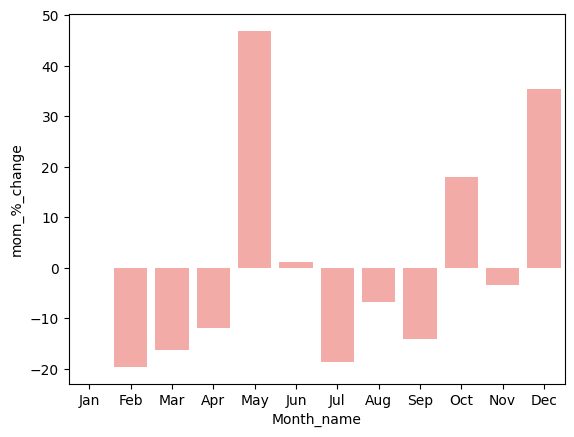

In [44]:
sns.barplot(x= 'Month_name', y = 'mom_%_change', color= 'r', data = mom_revv)

In [45]:
#mom diff and percentage change in expenses

tot_exp_by_month.head()

tot_exp_by_month['mom_diff'] = tot_exp_by_month['tot_exp'] - tot_exp_by_month['tot_exp'].shift(1)
tot_exp_by_month['mom_%_change'] = tot_exp_by_month['tot_exp'].pct_change().round(3)*100
tot_exp_by_month.fillna(0, inplace= True)


mom_expp = tot_exp_by_month

mom_expp


,mon_no,Month_name,tot_exp,mom_diff,mom_%_change
0,1,Jan,-1254500,0.0,0.0
1,2,Feb,-1089000,165500.0,-13.2
2,3,Mar,-1010800,78200.0,-7.2
3,4,Apr,-963400,47400.0,-4.7
4,5,May,-1230900,-267500.0,27.8
5,6,Jun,-1226100,4800.0,-0.4
6,7,Jul,-1111200,114900.0,-9.4
7,8,Aug,-1036300,74900.0,-6.7
8,9,Sep,-1029300,7000.0,-0.7
9,10,Oct,-1027400,1900.0,-0.2


<Axes: xlabel='Month_name', ylabel='mom_%_change'>

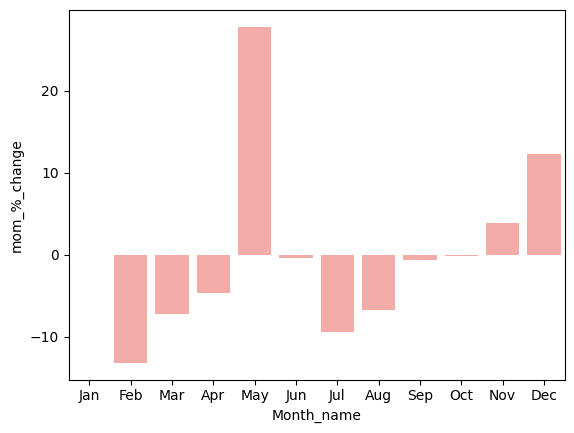

In [46]:
sns.barplot(x= 'Month_name', y = 'mom_%_change', color= 'r', data = mom_expp)

Now we look at quarterly analysis

In [47]:
#rev by quarter
trend_rev_by_qtr = trend_rev_extract.groupby('Quarter')['Amount'].sum().reset_index(name='tot_rev').sort_values('Quarter', ascending= True)
trend_rev_by_qtr['mom_diff'] = trend_rev_by_qtr['tot_rev'] - trend_rev_by_qtr['tot_rev'].shift(1)
trend_rev_by_qtr['mom_%_diff'] = trend_rev_by_qtr['tot_rev'].pct_change().round(3)*100
trend_rev_by_qtr.fillna(0, inplace = True)

trend_rev_by_qtr

,Quarter,tot_rev,mom_diff,mom_%_diff
0,qtr 1,4830050,0.0,0.0
1,qtr 2,4573800,-256250.0,-5.3
2,qtr 3,3825790,-748010.0,-16.4
3,qtr 4,4330180,504390.0,13.2


In [48]:
#change in expense by quarter
trend_exp_by_qtr = trend_exp_extract.groupby('Quarter')['Amount'].sum().reset_index(name='tot_exp').sort_values('Quarter', ascending= True)
trend_exp_by_qtr['mom_diff'] = trend_exp_by_qtr['tot_exp'] - trend_exp_by_qtr['tot_exp'].shift(1)
trend_exp_by_qtr['mom_%_diff'] = trend_exp_by_qtr['tot_exp'].pct_change().round(3)*100
trend_exp_by_qtr.fillna(0, inplace = True)

trend_exp_by_qtr

,Quarter,tot_exp,mom_diff,mom_%_diff
0,qtr 1,-3354300,0.0,0.0
1,qtr 2,-3420400,-66100.0,2.0
2,qtr 3,-3176800,243600.0,-7.1
3,qtr 4,-3294200,-117400.0,3.7


Now we shall look into Performance for each business lines and carry out a monthly and quarterly analysis

We shall start by assessing change in revenue and expenses for all business lines and expense subgroups

In [49]:
#month over month expenses difference and percentage difference for all three business lines
trend_exp_extract.head()

#expense by business line, exp group and subgroup
#Fin_data.groupby(['Month_name','Biz_line'])['Amount'].sum().reset_index(name= 'tot').sort_values(['Month_name', 'tot'], ascending= [True, False])
exp_by_biz_sub_grp = trend_exp_extract.groupby([ 'mon_no','Biz_line','Month_name'])['Amount'].sum().reset_index(name = 'tot_exp').sort_values(['Biz_line','mon_no', 'tot_exp'], ascending= [True, True, False])
exp_by_biz_sub_grp['mom_diff'] = exp_by_biz_sub_grp['tot_exp'] - exp_by_biz_sub_grp['tot_exp'].shift(1)
exp_by_biz_sub_grp['mom_%_diff'] = exp_by_biz_sub_grp['tot_exp'].pct_change().round(3)*100
exp_by_biz_sub_grp.fillna(0, inplace= True)
exp_by_biz_sub_grp.head()

,mon_no,Biz_line,Month_name,tot_exp,mom_diff,mom_%_diff
0,1,Nutrition and Food Supplements,Jan,-231500,0.0,0.0
3,2,Nutrition and Food Supplements,Feb,-230900,600.0,-0.3
6,3,Nutrition and Food Supplements,Mar,-212600,18300.0,-7.9
9,4,Nutrition and Food Supplements,Apr,-213800,-1200.0,0.6
12,5,Nutrition and Food Supplements,May,-233900,-20100.0,9.4


C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\2752230754.py:1: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:b'` for the same effect.

  sns.barplot(x = 'Month_name', y= 'mom_%_diff', hue= 'Biz_line', color = 'b', data= exp_by_biz_sub_grp)


<Axes: xlabel='Month_name', ylabel='mom_%_diff'>

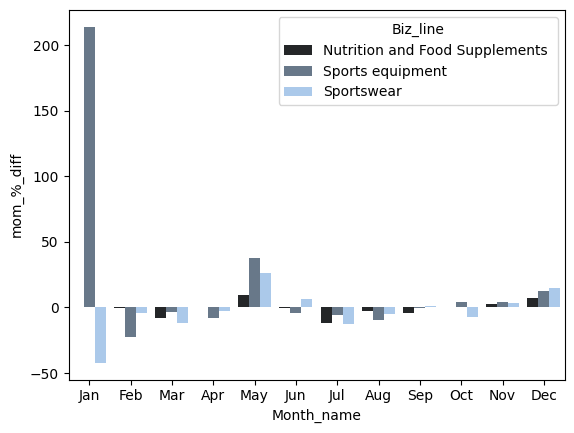

In [50]:
sns.barplot(x = 'Month_name', y= 'mom_%_diff', hue= 'Biz_line', color = 'b', data= exp_by_biz_sub_grp)

In [51]:
#we look into the mom diff and percentage diff in expenses for each business line

exp_by_biz_sub_grp = trend_exp_extract.groupby([ 'mon_no','Biz_line','Month_name'])['Amount'].sum().reset_index(name = 'tot_exp').sort_values(['Biz_line','mon_no', 'tot_exp'], ascending= [True, True, False])

def exp_mom_cal_and_pct(df):
    df['mom_diff'] = df['tot_exp'] - df['tot_exp'].shift(1)
    df['mom_%_diff'] = df['tot_exp'].pct_change().round(3)*100
    df.iloc[0, df.columns.get_loc('mom_diff')] = 0.0
    df.iloc[0, df.columns.get_loc('mom_%_diff')] = 0.0

    return df

exp_by_biz_sub_grp = exp_by_biz_sub_grp.groupby('Biz_line').apply(exp_mom_cal_and_pct).reset_index(drop= True)

exp_by_biz_sub_grp

C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\3093412946.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exp_by_biz_sub_grp = exp_by_biz_sub_grp.groupby('Biz_line').apply(exp_mom_cal_and_pct).reset_index(drop= True)


,mon_no,Biz_line,Month_name,tot_exp,mom_diff,mom_%_diff
0,1,Nutrition and Food Supplements,Jan,-231500,0.0,0.0
1,2,Nutrition and Food Supplements,Feb,-230900,600.0,-0.3
2,3,Nutrition and Food Supplements,Mar,-212600,18300.0,-7.9
3,4,Nutrition and Food Supplements,Apr,-213800,-1200.0,0.6
4,5,Nutrition and Food Supplements,May,-233900,-20100.0,9.4
5,6,Nutrition and Food Supplements,Jun,-233300,600.0,-0.3
6,7,Nutrition and Food Supplements,Jul,-205900,27400.0,-11.7
7,8,Nutrition and Food Supplements,Aug,-200900,5000.0,-2.4
8,9,Nutrition and Food Supplements,Sep,-192000,8900.0,-4.4
9,10,Nutrition and Food Supplements,Oct,-192300,-300.0,0.2


In [52]:
# month over month change in expenses for expense groups

exp_by_exp_grp = trend_exp_extract.groupby([ 'mon_no','Month_name','Biz_line' ,'Rev_exp_group'])['Amount'].sum().reset_index(name = 'tot_exp').sort_values(['Biz_line','Rev_exp_group','mon_no'], ascending= [True, True, True])
exp_by_exp_grp.groupby('Rev_exp_group').apply(exp_mom_cal_and_pct).reset_index(drop= True)

C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\4241562597.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exp_by_exp_grp.groupby('Rev_exp_group').apply(exp_mom_cal_and_pct).reset_index(drop= True)


,mon_no,Month_name,Biz_line,Rev_exp_group,tot_exp,mom_diff,mom_%_diff
0,1,Jan,Nutrition and Food Supplements,COGS,-94000,0.0,0.0
1,2,Feb,Nutrition and Food Supplements,COGS,-93400,600.0,-0.6
2,3,Mar,Nutrition and Food Supplements,COGS,-90700,2700.0,-2.9
3,4,Apr,Nutrition and Food Supplements,COGS,-91900,-1200.0,1.3
4,5,May,Nutrition and Food Supplements,COGS,-94300,-2400.0,2.6
5,6,Jun,Nutrition and Food Supplements,COGS,-94000,300.0,-0.3
6,7,Jul,Nutrition and Food Supplements,COGS,-76900,17100.0,-18.2
7,8,Aug,Nutrition and Food Supplements,COGS,-76900,0.0,0.0
8,9,Sep,Nutrition and Food Supplements,COGS,-75700,1200.0,-1.6
9,10,Oct,Nutrition and Food Supplements,COGS,-75700,0.0,0.0


In [53]:
# month over month change and percentage change in expenses for expense subgroups

exp_by_exp_sub_grp = trend_exp_extract.groupby([ 'mon_no','Expense_subgroup','Month_name'])['Amount'].sum().reset_index(name = 'tot_exp').sort_values(['Expense_subgroup','mon_no', 'tot_exp'], ascending= [True, True, False])
exp_by_exp_sub_grp =  exp_by_exp_sub_grp.groupby('Expense_subgroup').apply(exp_mom_cal_and_pct).reset_index(drop = True)



C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\1592899084.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  exp_by_exp_sub_grp =  exp_by_exp_sub_grp.groupby('Expense_subgroup').apply(exp_mom_cal_and_pct).reset_index(drop = True)


<Axes: xlabel='Month_name', ylabel='mom_%_diff'>

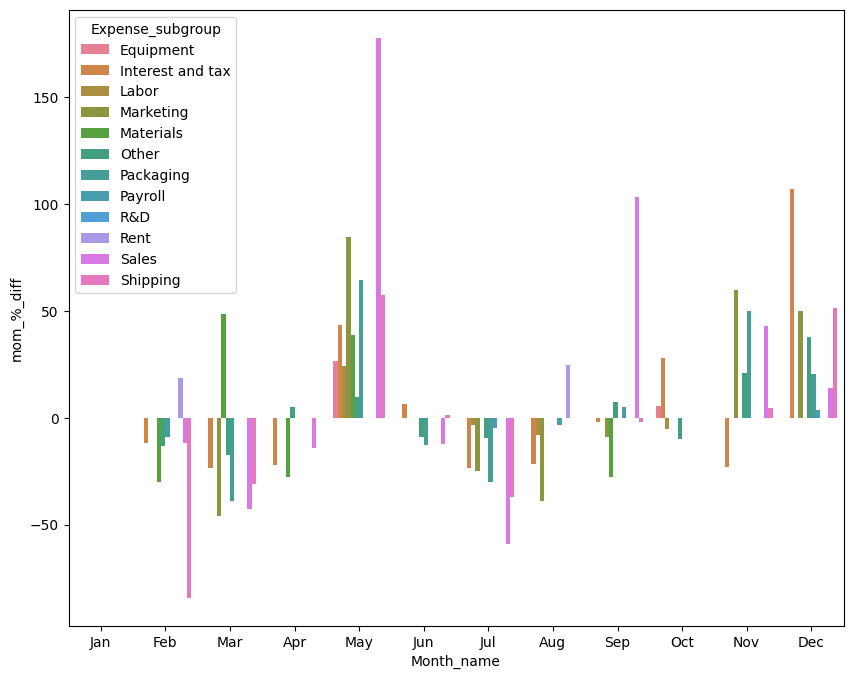

In [54]:
plt.figure(figsize =(10, 8))
sns.barplot(x= 'Month_name', y= 'mom_%_diff', hue= 'Expense_subgroup', data= exp_by_exp_sub_grp)

In [55]:
#now we look into  month over month difference in revenue genrated from all business lines, rev group 

rev_by_biz_line =trend_rev_extract.groupby(['mon_no', 'Month_name', 'Biz_line'])['Amount'].sum().reset_index(name= 'tot_rev').sort_values(['Biz_line', 'mon_no'], ascending = [True, True])

#now we define the function to calculate our mom_diff and percentage change in revenue

def rev_mom_and_pct(df):
    df['mom_diff'] = df['tot_rev'] - df['tot_rev'].shift(1)
    df['mom_%_diff'] = df['tot_rev'].pct_change().round(3)*100
    df.iloc[0, df.columns.get_loc('mom_diff')] = 0.0
    df.iloc[0, df.columns.get_loc('mom_%_diff')] = 0.0
    return df

rev = rev_by_biz_line.groupby('Biz_line').apply(rev_mom_and_pct).reset_index(drop = True)
rev

C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\503075658.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rev = rev_by_biz_line.groupby('Biz_line').apply(rev_mom_and_pct).reset_index(drop = True)


,mon_no,Month_name,Biz_line,tot_rev,mom_diff,mom_%_diff
0,1,Jan,Nutrition and Food Supplements,186000,0.0,0.0
1,2,Feb,Nutrition and Food Supplements,163200,-22800.0,-12.3
2,3,Mar,Nutrition and Food Supplements,127350,-35850.0,-22.0
3,4,Apr,Nutrition and Food Supplements,108600,-18750.0,-14.7
4,5,May,Nutrition and Food Supplements,159000,50400.0,46.4
5,6,Jun,Nutrition and Food Supplements,185700,26700.0,16.8
6,7,Jul,Nutrition and Food Supplements,145050,-40650.0,-21.9
7,8,Aug,Nutrition and Food Supplements,207750,62700.0,43.2
8,9,Sep,Nutrition and Food Supplements,135390,-72360.0,-34.8
9,10,Oct,Nutrition and Food Supplements,130725,-4665.0,-3.4


<Axes: xlabel='Month_name', ylabel='mom_%_diff'>

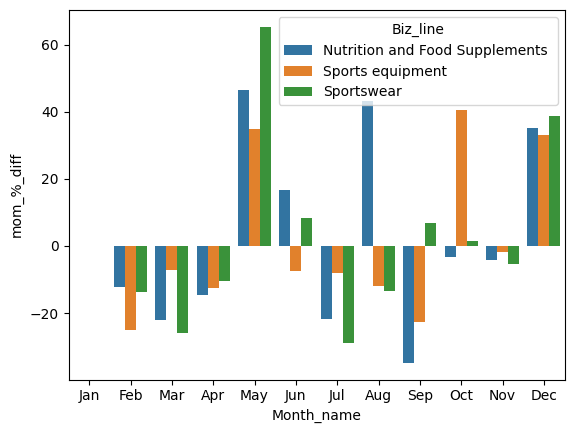

In [56]:
sns.barplot(x= 'Month_name', y= 'mom_%_diff', hue= 'Biz_line', data= rev )

In [57]:
# month over month change and percentage change in revenue generated by various revenue groups

rev_by_rev_group = trend_rev_extract.groupby(['mon_no', 'Rev_exp_group', 'Month_name'])['Amount'].sum().reset_index(name= 'tot_rev').sort_values(['Rev_exp_group', 'mon_no'], ascending = [True, True])

rev_by_rev_group.groupby('Rev_exp_group').apply(rev_mom_and_pct).reset_index(drop = True)

C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\801339226.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rev_by_rev_group.groupby('Rev_exp_group').apply(rev_mom_and_pct).reset_index(drop = True)


,mon_no,Rev_exp_group,Month_name,tot_rev,mom_diff,mom_%_diff
0,1,Consulting and professional services,Jan,495000,0.0,0.0
1,2,Consulting and professional services,Feb,292500,-202500.0,-40.9
2,3,Consulting and professional services,Mar,195000,-97500.0,-33.3
3,4,Consulting and professional services,Apr,193500,-1500.0,-0.8
4,5,Consulting and professional services,May,280800,87300.0,45.1
5,6,Consulting and professional services,Jun,289200,8400.0,3.0
6,7,Consulting and professional services,Jul,169500,-119700.0,-41.4
7,8,Consulting and professional services,Aug,210000,40500.0,23.9
8,9,Consulting and professional services,Sep,138000,-72000.0,-34.3
9,10,Consulting and professional services,Oct,142800,4800.0,3.5


In [58]:
#overall month over month diff in revenue generated and expenses incurred

rev_exp = Fin_data.groupby(['mon_no', 'Rev_or_exp', 'Month_name'])['Amount'].sum().reset_index(name= 'tot').sort_values(['Rev_or_exp', 'mon_no'], ascending = [True, True])

#now we define our mom and pct diff function

def mom_pct_diff(df):
    df['mom_diff'] = df['tot'] - df['tot'].shift(1)
    df['mom_%_diff'] = df['tot'].pct_change().round(3)*100
    df.iloc[0, df.columns.get_loc('mom_diff')] = 0.0
    df.iloc[0, df.columns.get_loc('mom_%_diff')] = 0.0
    return df

rev_exp_02= rev_exp.groupby('Rev_or_exp').apply(mom_pct_diff).reset_index(drop= True)
rev_exp_02



C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\2368620440.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rev_exp_02= rev_exp.groupby('Rev_or_exp').apply(mom_pct_diff).reset_index(drop= True)


,mon_no,Rev_or_exp,Month_name,tot,mom_diff,mom_%_diff
0,1,Expense,Jan,-1254500,0.0,0.0
1,2,Expense,Feb,-1089000,165500.0,-13.2
2,3,Expense,Mar,-1010800,78200.0,-7.2
3,4,Expense,Apr,-963400,47400.0,-4.7
4,5,Expense,May,-1230900,-267500.0,27.8
5,6,Expense,Jun,-1226100,4800.0,-0.4
6,7,Expense,Jul,-1111200,114900.0,-9.4
7,8,Expense,Aug,-1036300,74900.0,-6.7
8,9,Expense,Sep,-1029300,7000.0,-0.7
9,10,Expense,Oct,-1027400,1900.0,-0.2


C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\1244399306.py:1: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:g'` for the same effect.

  sns.barplot(x = 'Month_name', y= 'mom_%_diff', hue= 'Rev_or_exp', color= 'g', data = rev_exp_02)


<Axes: xlabel='Month_name', ylabel='mom_%_diff'>

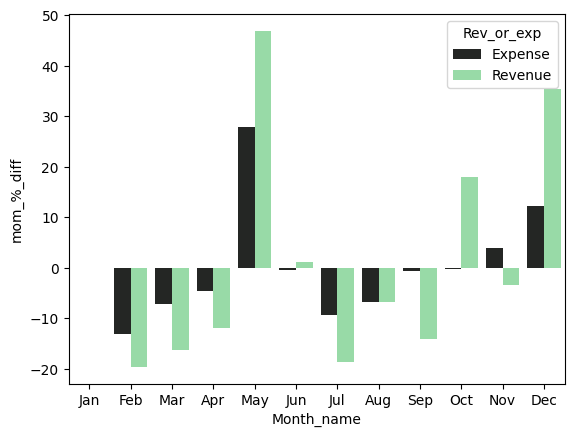

In [59]:
sns.barplot(x = 'Month_name', y= 'mom_%_diff', hue= 'Rev_or_exp', color= 'g', data = rev_exp_02)

Profit analysis

Here we will deive into the following:
gross profit across business line and sub groups
Trend analysis for gross profit across business lines and subgroups

In [60]:
trend_rev_extract.head()

,Month_name,mon_no,Quarter,week,week_day,Biz_line,Rev_exp_group,Rev_or_exp,Amount
0,Jan,1,qtr 1,week 5,Tuesday,Nutrition and Food Supplements,Sales,Revenue,153000
1,Jan,1,qtr 1,week 5,Tuesday,Nutrition and Food Supplements,Consulting and professional services,Revenue,27000
2,Jan,1,qtr 1,week 5,Tuesday,Nutrition and Food Supplements,Other income,Revenue,6000
16,Feb,2,qtr 1,week 4,Tuesday,Nutrition and Food Supplements,Consulting and professional services,Revenue,22500
17,Mar,3,qtr 1,week 4,Friday,Nutrition and Food Supplements,Consulting and professional services,Revenue,9000


In [61]:
trend_exp_extract.head()

,Month_name,mon_no,Quarter,week,week_day,Biz_line,Rev_exp_group,Expense_subgroup,Rev_or_exp,Amount
3,Jan,1,qtr 1,week 5,Tuesday,Nutrition and Food Supplements,Opex,Rent,Expense,-15000
4,Jan,1,qtr 1,week 5,Tuesday,Nutrition and Food Supplements,Opex,Equipment,Expense,-9000
5,Jan,1,qtr 1,week 5,Tuesday,Nutrition and Food Supplements,Opex,Marketing,Expense,-30000
6,Jan,1,qtr 1,week 5,Tuesday,Nutrition and Food Supplements,Opex,Payroll,Expense,-40000
7,Jan,1,qtr 1,week 5,Tuesday,Nutrition and Food Supplements,Opex,R&D,Expense,-30000


##identifying profit margin across business lines
profit_margin_ext = Fin_data.groupby(['Rev_or_exp', 'Biz_line', 'Rev_exp_group'])['Amount'].sum().reset_index(name= 'total')

profit_margin = profit_margin_ext.pivot(index = ['Biz_line', 'Rev_exp_group'], columns= 'Rev_or_exp', values= 'total')
profit_margin['Prof_margin'] = profit_margin['Revenue'] + profit_margin['Expense']
profit_margin


In [62]:
# Gross profit across all business lines

def gp_ext(df):
   Expenses = df.loc[df['Rev_exp_group'] == 'COGS', 'Amount'].sum()
   Revenue = df.loc[df['Rev_or_exp'] == 'Revenue', 'Amount'].sum()

   return  pd.DataFrame({'Biz_line': [df.name], 'Revenue': [Revenue], 'Expenses': [Expenses]})

prof_mar_ext = Fin_data[['Rev_or_exp', 'Biz_line', 'Rev_exp_group', 'Amount']]
gross_profit = prof_mar_ext.groupby('Biz_line').apply(gp_ext).reset_index(drop= True)

gross_profit['Gross_profit'] = gross_profit['Revenue'] + gross_profit['Expenses']
gross_profit

C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\2802251392.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gross_profit = prof_mar_ext.groupby('Biz_line').apply(gp_ext).reset_index(drop= True)


,Biz_line,Revenue,Expenses,Gross_profit
0,Nutrition and Food Supplements,1843620,-1017300,826320
1,Sports equipment,8908500,-3674200,5234300
2,Sportswear,6807700,-2020000,4787700


<Axes: xlabel='Biz_line', ylabel='Gross_profit'>

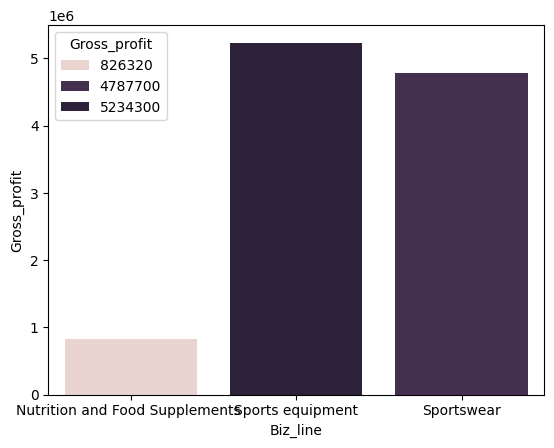

In [63]:
sns.barplot(x = 'Biz_line', y= 'Gross_profit', hue= 'Gross_profit',  data= gross_profit)

In [64]:
# general gross profit over month
 
def gp_by_mon(df):
   Expenses = df.loc[df['Rev_exp_group'] == 'COGS', 'Amount'].sum()
   Revenue = df.loc[df['Rev_or_exp'] == 'Revenue', 'Amount'].sum()
   Month_name = df['Month_name'].iloc[0]
   mon_no = df['mon_no'].iloc[0]
   return  pd.DataFrame({'mon_no': [mon_no],'Month_name': [Month_name],'Revenue': [Revenue], 'Expenses': [Expenses]})

mom_gross_profit_ext = Fin_data[['mon_no','Month_name','Rev_or_exp', 'Rev_exp_group', 'Amount']]
gp_by_month = mom_gross_profit_ext.groupby(['mon_no','Month_name']).apply(gp_by_mon).reset_index(drop= True).sort_values('mon_no', ascending= True)

gp_by_month['Gross_profit'] = gp_by_month['Revenue'] + gp_by_month['Expenses']
gp_by_month

# month over month change in gross profit

gp_by_month['mom_diff'] = gp_by_month['Gross_profit'] -  gp_by_month['Gross_profit'].shift(1)
gp_by_month['mom_%_diff'] = gp_by_month['Gross_profit'].pct_change().round(3)*100

mom_gp_by_mon = gp_by_month
mom_gp_by_mon.fillna(0)


C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\478927505.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp_by_month = mom_gross_profit_ext.groupby(['mon_no','Month_name']).apply(gp_by_mon).reset_index(drop= True).sort_values('mon_no', ascending= True)


,mon_no,Month_name,Revenue,Expenses,Gross_profit,mom_diff,mom_%_diff
0,1,Jan,1949000,-662600,1286400,0.0,0.0
1,2,Feb,1567700,-507000,1060700,-225700.0,-17.5
2,3,Mar,1313350,-513500,799850,-260850.0,-24.6
3,4,Apr,1156100,-482900,673200,-126650.0,-15.8
4,5,May,1698500,-641900,1056600,383400.0,57.0
5,6,Jun,1719200,-634600,1084600,28000.0,2.7
6,7,Jul,1400050,-580900,819150,-265450.0,-24.5
7,8,Aug,1304850,-546900,757950,-61200.0,-7.5
8,9,Sep,1120890,-535900,584990,-172960.0,-22.8
9,10,Oct,1322475,-515900,806575,221585.0,37.9


In [65]:
# df_melted = mom_gp_by_mon.melt(id_vars='Month_name', value_vars=['Revenue', 'Expenses'], 
#                                var_name='Type', value_name='Amount')

# df_melted

<Axes: xlabel='Month_name', ylabel='mom_%_diff'>

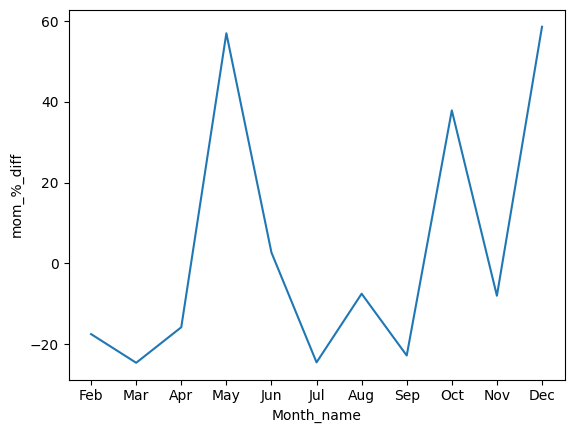

In [66]:
sns.lineplot(x = 'Month_name', y= 'mom_%_diff', data = mom_gp_by_mon  )

In [67]:
#identifying gross profit across biz_line over months

def gp_bizline(df):
   Expenses = df.loc[df['Rev_exp_group'] == 'COGS', 'Amount'].sum()
   Revenue = df.loc[df['Rev_or_exp'] == 'Revenue', 'Amount'].sum()
   Month_name = df['Month_name'].iloc[0]
   mon_no = df['mon_no'].iloc[0]
   Biz_line = df['Biz_line'].iloc[0]
   return  pd.DataFrame({'mon_no': [mon_no],'Month_name': [Month_name],'Biz_line': [Biz_line], 'Revenue': [Revenue], 'Expenses': [Expenses]})

gp_biz_line_ext = Fin_data[['mon_no','Month_name','Rev_or_exp', 'Biz_line', 'Rev_exp_group', 'Amount']]
gp_biz_line_by_mon = gp_biz_line_ext.groupby(['mon_no','Month_name','Biz_line']).apply(gp_bizline).reset_index(drop= True).sort_values(['Biz_line', 'mon_no'], ascending= [True, True])

gp_biz_line_by_mon['Gross_profit'] = gp_biz_line_by_mon['Revenue'] + gp_biz_line_by_mon['Expenses']
gp_biz_line_by_mon.head()


C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\1221078824.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gp_biz_line_by_mon = gp_biz_line_ext.groupby(['mon_no','Month_name','Biz_line']).apply(gp_bizline).reset_index(drop= True).sort_values(['Biz_line', 'mon_no'], ascending= [True, True])


,mon_no,Month_name,Biz_line,Revenue,Expenses,Gross_profit
0,1,Jan,Nutrition and Food Supplements,186000,-94000,92000
3,2,Feb,Nutrition and Food Supplements,163200,-93400,69800
6,3,Mar,Nutrition and Food Supplements,127350,-90700,36650
9,4,Apr,Nutrition and Food Supplements,108600,-91900,16700
12,5,May,Nutrition and Food Supplements,159000,-94300,64700


In [68]:
# month over month change in gross profit across all business lines

def mom_gp_pct_biz_line(df):
    df['mon_diff'] = df['Gross_profit'] - df['Gross_profit'].shift(1)
    df['mom_%_diff'] = df['Gross_profit'].pct_change().round(3)*100
    df.iloc[0, df.columns.get_loc('mon_diff')] = 0.0
    df.iloc[0, df.columns.get_loc('mom_%_diff')] = 0.0
    df.fillna(0, inplace = True)
    return df

mom_gp_by_biz_line = gp_biz_line_by_mon.groupby('Biz_line').apply(mom_gp_pct_biz_line).reset_index(drop = True)
mom_gp_by_biz_line

C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\619781352.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mom_gp_by_biz_line = gp_biz_line_by_mon.groupby('Biz_line').apply(mom_gp_pct_biz_line).reset_index(drop = True)


,mon_no,Month_name,Biz_line,Revenue,Expenses,Gross_profit,mon_diff,mom_%_diff
0,1,Jan,Nutrition and Food Supplements,186000,-94000,92000,0.0,0.0
1,2,Feb,Nutrition and Food Supplements,163200,-93400,69800,-22200.0,-24.1
2,3,Mar,Nutrition and Food Supplements,127350,-90700,36650,-33150.0,-47.5
3,4,Apr,Nutrition and Food Supplements,108600,-91900,16700,-19950.0,-54.4
4,5,May,Nutrition and Food Supplements,159000,-94300,64700,48000.0,287.4
5,6,Jun,Nutrition and Food Supplements,185700,-94000,91700,27000.0,41.7
6,7,Jul,Nutrition and Food Supplements,145050,-76900,68150,-23550.0,-25.7
7,8,Aug,Nutrition and Food Supplements,207750,-76900,130850,62700.0,92.0
8,9,Sep,Nutrition and Food Supplements,135390,-75700,59690,-71160.0,-54.4
9,10,Oct,Nutrition and Food Supplements,130725,-75700,55025,-4665.0,-7.8


In [69]:
# Operating Expenses analysis OPEX

opex_extract = trend_exp_extract.loc[trend_exp_extract['Rev_exp_group'] == 'Opex', ['Month_name', 'mon_no', 'Biz_line', 'Expense_subgroup', 'Amount']]
opex_extract

#opex by month

opex_by_mon = opex_extract.groupby(['mon_no', 'Month_name'])['Amount'].sum().reset_index(name= 'opex').sort_values('mon_no', ascending= True)

#opex across business lines

opex_biz_line = opex_extract.groupby('Biz_line')['Amount'].sum().reset_index(name = 'opex').sort_values('Biz_line',ascending = True)

#total ebit by across business lines by month

opex_by_mon_biz_line = opex_extract.groupby(['Biz_line', 'mon_no', 'Month_name'])['Amount'].sum().reset_index(name = 'tot_exp').sort_values(['Biz_line', 'mon_no', 'tot_exp'], ascending = [True, True, False])
opex_by_mon_biz_line.head()


# month over month difference in ebit across business lines
mom_opex = opex_by_mon_biz_line.groupby('Biz_line').apply(exp_mom_cal_and_pct).reset_index(drop= True)
mom_opex

#sns.lineplot(x= 'Month_name', y= 'mom_%_diff', hue= 'Biz_line', data= mom_opex)

C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\2751987549.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mom_opex = opex_by_mon_biz_line.groupby('Biz_line').apply(exp_mom_cal_and_pct).reset_index(drop= True)


,Biz_line,mon_no,Month_name,tot_exp,mom_diff,mom_%_diff
0,Nutrition and Food Supplements,1,Jan,-125500,0.0,0.0
1,Nutrition and Food Supplements,2,Feb,-125500,0.0,0.0
2,Nutrition and Food Supplements,3,Mar,-109900,15600.0,-12.4
3,Nutrition and Food Supplements,4,Apr,-109900,0.0,0.0
4,Nutrition and Food Supplements,5,May,-127600,-17700.0,16.1
5,Nutrition and Food Supplements,6,Jun,-127300,300.0,-0.2
6,Nutrition and Food Supplements,7,Jul,-117000,10300.0,-8.1
7,Nutrition and Food Supplements,8,Aug,-112000,5000.0,-4.3
8,Nutrition and Food Supplements,9,Sep,-104300,7700.0,-6.9
9,Nutrition and Food Supplements,10,Oct,-104600,-300.0,0.3


In [70]:

opex_biz_line

# momth over month ebit diff across business lines

,Biz_line,opex
0,Nutrition and Food Supplements,-1395200
1,Sports equipment,-2533600
2,Sportswear,-1676000


In [71]:
gross_profit_ebit = gross_profit[['Biz_line', 'Gross_profit']]
gross_profit_ebit

,Biz_line,Gross_profit
0,Nutrition and Food Supplements,826320
1,Sports equipment,5234300
2,Sportswear,4787700


In [72]:
# Expenses Before Interests and Taxes analysis
ebit = gross_profit_ebit.merge(opex_biz_line, on= 'Biz_line', how= 'left')
ebit

#overall ebit analysis
gp = ebit['Gross_profit'].sum()
opex = ebit['opex'].sum()
ebit_df = pd.DataFrame({'gp': [gp], 
                       'opex': [opex]})

ebit_df['ebit'] = ebit_df['gp'] + ebit_df['opex']

ebit_df

,gp,opex,ebit
0,10848320,-5604800,5243520


In [73]:
#ebit by business line
ebit['ebit'] = ebit['Gross_profit'] + ebit['opex']
ebit


,Biz_line,Gross_profit,opex,ebit
0,Nutrition and Food Supplements,826320,-1395200,-568880
1,Sports equipment,5234300,-2533600,2700700
2,Sportswear,4787700,-1676000,3111700


In [74]:
#expenses before interest and taxes across months

ebit_by_mon_ext = opex_by_mon.merge(gp_by_month, on= 'Month_name', how= 'inner')
ebit_by_mon = ebit_by_mon_ext[['mon_no_x', 'Month_name', 'Gross_profit', 'opex']]


ebit_by_mon['ebit'] = ebit_by_mon['Gross_profit'] + ebit_by_mon['opex']
ebit_by_mon

#month over month change in ebit
ebit_by_mon['mom_diff'] = ebit_by_mon['ebit'] - ebit_by_mon['ebit'].shift(1)
ebit_by_mon['mom_%_diff'] = ebit_by_mon['ebit'].pct_change().round(3)*100
ebit_by_mon.fillna(0)



C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\276059908.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebit_by_mon['ebit'] = ebit_by_mon['Gross_profit'] + ebit_by_mon['opex']
C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\276059908.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebit_by_mon['mom_diff'] = ebit_by_mon['ebit'] - ebit_by_mon['ebit'].shift(1)
C:\Users\djibr\AppData\Local\Temp\ipykernel_19304\276059908.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,mon_no_x,Month_name,Gross_profit,opex,ebit,mom_diff,mom_%_diff
0,1,Jan,1286400,-478900,807500,0.0,0.0
1,2,Feb,1060700,-482500,578200,-229300.0,-28.4
2,3,Mar,799850,-421300,378550,-199650.0,-34.5
3,4,Apr,673200,-421300,251900,-126650.0,-33.5
4,5,May,1056600,-504200,552400,300500.0,119.3
5,6,Jun,1084600,-501100,583500,31100.0,5.6
6,7,Jul,819150,-461000,358150,-225350.0,-38.6
7,8,Aug,757950,-435000,322950,-35200.0,-9.8
8,9,Sep,584990,-440100,144890,-178060.0,-55.1
9,10,Oct,806575,-443200,363375,218485.0,150.8


In [75]:
mom_opex.head()

,Biz_line,mon_no,Month_name,tot_exp,mom_diff,mom_%_diff
0,Nutrition and Food Supplements,1,Jan,-125500,0.0,0.0
1,Nutrition and Food Supplements,2,Feb,-125500,0.0,0.0
2,Nutrition and Food Supplements,3,Mar,-109900,15600.0,-12.4
3,Nutrition and Food Supplements,4,Apr,-109900,0.0,0.0
4,Nutrition and Food Supplements,5,May,-127600,-17700.0,16.1


Interest and tax analysis

In [76]:
int_tax = Fin_data[Fin_data['Expense_subgroup'] == 'Interest and tax'].head()

int_tax_biz_line = int_tax.groupby('Biz_line')['Amount'].sum().reset_index(name= 'tot_int_tax'). sort_values('tot_int_tax', ascending = False)
int_tax_biz_line 

,Biz_line,tot_int_tax
0,Nutrition and Food Supplements,-60000


In [77]:
#Net profit calculation

int_tax_ext = Fin_data.loc[Fin_data['Expense_subgroup'] == 'Interest and tax', ['mon_no', 'Month_name', 'Amount']]
int_tax_ext

int_tax_by_mon = int_tax_ext.groupby(['mon_no','Month_name'])['Amount'].sum().reset_index(name= 'int_tax').sort_values('mon_no', ascending = True)
int_tax_by_mon

#tax and ebit merge

net_prof_cal = ebit_by_mon.merge(int_tax_by_mon, on= 'Month_name', how = 'left')
net_prof_cal

#now we calculate the net profit

net_prof_cal['net_profit'] = net_prof_cal['ebit'] + net_prof_cal['int_tax']
net_prof_cal

#Now we calculate the month over month change in net profit

net_prof_cal['net_mom_diff'] = net_prof_cal['net_profit'] - net_prof_cal['net_profit'].shift(1)
net_prof_cal['net_mom_%_diff'] = net_prof_cal['net_profit'].pct_change().round(3)*100

net_prof_cal.fillna(0, inplace= True)

net_prof_cal


,mon_no_x,Month_name,Gross_profit,opex,ebit,mom_diff,mom_%_diff,mon_no,int_tax,net_profit,net_mom_diff,net_mom_%_diff
0,1,Jan,1286400,-478900,807500,0.0,0.0,1,-113000,694500,0.0,0.0
1,2,Feb,1060700,-482500,578200,-229300.0,-28.4,2,-99500,478700,-215800.0,-31.1
2,3,Mar,799850,-421300,378550,-199650.0,-34.5,3,-76000,302550,-176150.0,-36.8
3,4,Apr,673200,-421300,251900,-126650.0,-33.5,4,-59200,192700,-109850.0,-36.3
4,5,May,1056600,-504200,552400,300500.0,119.3,5,-84800,467600,274900.0,142.7
5,6,Jun,1084600,-501100,583500,31100.0,5.6,6,-90400,493100,25500.0,5.5
6,7,Jul,819150,-461000,358150,-225350.0,-38.6,7,-69300,288850,-204250.0,-41.4
7,8,Aug,757950,-435000,322950,-35200.0,-9.8,8,-54400,268550,-20300.0,-7.0
8,9,Sep,584990,-440100,144890,-178060.0,-55.1,9,-53300,91590,-176960.0,-65.9
9,10,Oct,806575,-443200,363375,218485.0,150.8,10,-68300,295075,203485.0,222.2


In [78]:
Fin_data.head()

,Year,Month_name,Month_sequence,Date,Biz_line,Amount,Expense_subgroup,Rev_exp_group,Rev_or_exp,week,Quarter,mon_no,mon_day,week_day
0,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,153000,NaN,Sales,Revenue,week 5,qtr 1,1,31,Tuesday
1,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,27000,NaN,Consulting and professional services,Revenue,week 5,qtr 1,1,31,Tuesday
2,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,6000,NaN,Other income,Revenue,week 5,qtr 1,1,31,Tuesday
3,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,-15000,Rent,Opex,Expense,week 5,qtr 1,1,31,Tuesday
4,2023,Jan,1,2023-01-31,Nutrition and Food Supplements,-9000,Equipment,Opex,Expense,week 5,qtr 1,1,31,Tuesday


Predictive analytics

Revenue Forecast

In [79]:
trend_rev_extract
rev_forecast_ext = Fin_data.loc[Fin_data['Rev_or_exp'] == 'Revenue', ['Date', 'Year', 'Month_name', 'mon_no', 'Quarter', 'week_day', 'mon_day', 'Biz_line', 'Rev_exp_group', 'Amount']]
rev_forecast_ext

x = rev_forecast_ext[['Year','mon_no']]
y = rev_forecast_ext['Amount']

#to split our data into training and test data

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.2, random_state= 42)

#Now we select our model
model = LinearRegression()

#to train the model

model.fit(x_train, y_train)
#to predict using the model
y_pred = model.predict(x_test)

#to confirm the model/evaluate performance

mse = mean_squared_error(y_test, y_pred)

print(mse)




37124311932.979256


In [80]:
from prophet import Prophet